In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import pathlib

In [ ]:
input_ = tf.keras.layers.Input(shape=(224, 224, 1), name="INPUT")
normalization = tf.keras.layers.Rescaling(1./255)(input_) # Standardize the data
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), strides=1, activation="relu", name="CONV1")(normalization) 
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL1")(conv1) 
conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), strides=1, activation="relu", name="CONV2")(pool1)
concat1 = tf.keras.layers.Concatenate()([pool1, conv2])

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL2")(concat1)
conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, activation="relu", name="CONV3")(pool2)
concat2 = tf.keras.layers.Concatenate()([pool2, conv3])

pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL3")(concat2)
conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, activation="relu", name="CONV4")(pool3)
concat3 = tf.keras.layers.Concatenate()([pool3, conv4])

pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL4")(concat3)
flatten = tf.keras.layers.Flatten()(pool4)
fc1 = tf.keras.layers.Dense(4096, activation='relu')(flatten)
fc2 = tf.keras.layers.Dense(2048, activation='relu')(fc1)

output = tf.keras.layers.Dense(7, activation='softmax')(fc2)

model = tf.keras.Model(
    inputs=[input_],
    outputs=[output]
)

Load in / prep the data

In [3]:
data_dir = pathlib.Path("Train").with_suffix('')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

2735

In [ ]:
angry = list(data_dir.glob('Angry/*'))
Image.open(str(angry[0]))

In [ ]:
im_size = (224, 224)
val_split = 0.1
batch_size = 32
seed_ = 11
mode = "grayscale"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="training",
    seed=seed_,
    image_size=(im_size),
    batch_size=batch_size,
    color_mode=mode
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="validation",
    seed=seed_,
    image_size=(im_size),
    batch_size=batch_size,
    color_mode=mode
)

In [8]:
model.compile( 
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=3,
    validation_data=(val_ds)
)

Make Predictions

In [ ]:
test_dir = pathlib.Path("Test").with_suffix('')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=batch_size,
    color_mode=mode
)

In [ ]:
predicted = []
actual = []

for images, labels in test_ds:
    probabilities = model.predict(images)

    for pred in probabilities:
        predicted.append(np.argmax(pred))
    
    actual = labels.numpy()


In [ ]:
expressions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

for i in range(len(actual)):
    print(f"Actual={expressions[actual[i]]}, Predicted={expressions[predicted[i]]}")


Confusion Matrix

In [44]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [47]:
array = tf.math.confusion_matrix(labels=actual, predictions=predicted)

<Axes: >

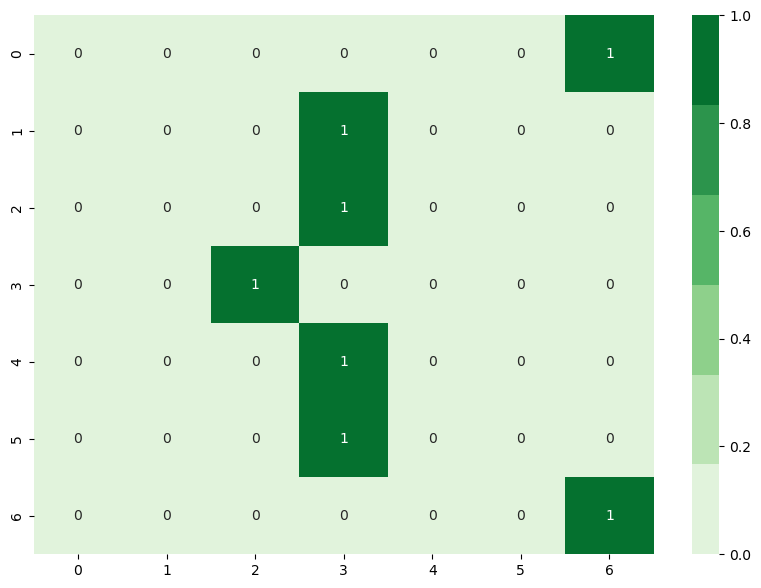

In [48]:
plt.figure(figsize=(10,7))
sns.heatmap(array, annot=True, cmap=sns.color_palette("Greens"))

Model Metrics

In [53]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [71]:
l = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [ ]:
print(f"F1-Score: {dict( zip( l, f1_score(actual, predicted, average=None)) )}")
print(f"Accuracy: {accuracy_score(actual, predicted)}")
print(f"Precision: {precision_score(actual, predicted, average=None)}")
print(f"Recall: {recall_score(actual, predicted, average=None)}")